По материалам 16 семинара провести исследование по тематическому моделированию и разработать рекомендательную систему.

* рекомендательная система обучается на корпусе текстов, в качестве корпуса текстов использовать 20 news groups из scikit-learn
* пользователь предъявляет образец текста (не обязательно из обучающего корпуса) и просит показать k похожих по тематике текстов
* в качестве моделей для тематического моделирования рассмотреть NMF, LSA, LDA
* в качестве метрик topic coherence рассмотреть TC-W2C, UCI, Umass
* для каждой тематической модели определить оптимальное кол-во тем, а затем сравнить сами модели с помощью метрик topic coherence
* при выборе оптимального кол-ва тем постройте проверяйте дескрипторы тем
* таким образом, для каждой метрики вы получите свою оптимальную модель. Сравните дескрипторы тем у этих моделей, и выберите
* таким образом, вы получите тематическое представление для каждого документа. Выберите функцию расстояния между документами, посмотрите sklearn.metrics
* при поиске ближайших соседей используйте sklearn.neighbors
* работу оформить в виде ноутбука *.ipynb
* продемонстрируйте работу вашей рекомендательной системы на текстах из обучающего корпуса и текстах из bbc news за 2017 год

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

## Preprocess data

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
docs = dataset.data

In [3]:
# custom stopwords
custom_stop_words = []
with open( "./data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [4]:
raw_documents = []
snippets = []
for i in docs:
    text = i.strip()
    raw_documents.append( text.lower() )   
    snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 11314 raw text documents


In [5]:
vectorizer = TfidfVectorizer(min_df=20, stop_words=custom_stop_words)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names()
joblib.dump((A,terms, snippets), "articles-tfidf.pkl")

Created 11314 X 6004 TF-IDF-normalized document-term matrix


['articles-tfidf.pkl']

In [6]:
import operator


sums = np.array(A.sum(axis=0)).ravel()
# map weights to the terms
weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate( ranking[0:20] ):
    print( "%s (%.2f)" % ( pair[0], pair[1] ) )

know (183.69)
get (172.95)
people (160.03)
think (156.97)
good (133.11)
thanks (133.07)
time (127.37)
please (118.39)
edu (108.17)
see (102.61)
god (101.83)
need (101.57)
way (100.23)
want (98.14)
right (97.48)
problem (95.40)
system (94.64)
windows (93.58)
something (90.52)
really (89.58)


## NMF

In [8]:
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")

# create the model
k = 10
modelNMF = NMF( init="nndsvd", n_components=k ) 

W = modelNMF.fit_transform( A )
H = modelNMF.components_

In [23]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: car, get, think, good, know, time, people, right, bike, back, see, really, go, way, space, long, something, going, thing, lot
Topic 02: people, key, government, know, get, edu, think, time, please, good, com, number, information, right, law, public, encryption, list, clipper, want
Topic 03: thanks, windows, drive, card, please, know, get, problem, file, need, system, mail, dos, software, pc, hi, program, help, files, mac
Topic 04: god, jesus, people, israel, believe, bible, think, christian, jews, christians, know, true, faith, christ, see, israeli, church, life, way, religion


## LDA

In [60]:
k = 12
modelLDA = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)

W = modelLDA.fit_transform( A )
H = model.components_

In [61]:
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: people, think, know, get, time, see, right, good, really, something, want, going, way, things, take, thing, gun, believe, sure, point
Topic 02: thanks, please, mail, know, advance, hi, looking, info, email, help, anybody, address, appreciated, information, post, send, someone, interested, need, reply
Topic 03: geb, cadre, dsl, n3jxp, chastity, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, usually
Topic 04: god, jesus, bible, christ, faith, believe, christian, christians, church, sin, life, heaven, lord, truth, hell, belief, man, christianity, father, son
Topic 05: key, chip, encryption, clipper, keys, government, system, escrow, algorithm, public, security, law, nsa, phone, secure, des, bit, encrypted, privacy, chips
Topic 06: drive, scsi, drives, disk, hard, ide, controller, floppy, cd, system, mac, hd, boot, tape, cable, internal, rom, problem, power, seagate
Topic 07: windows, file, dos, files, progr

## LSA

In [48]:
k = 10
modelLSA = TruncatedSVD(n_components=k ) 

W = modelLSA.fit_transform( A )
H = modelLSA.components_

In [13]:
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: know, people, get, think, good, time, thanks, god, please, see, want, way, need, right, system, windows, problem, edu, something, really
Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, government, see, christ, faith, law, right, israel, religion, jews, fact, against
Topic 03: geb, cadre, pitt, dsl, chastity, n3jxp, shameful, edu, intellect, skepticism, surrender, gordon, banks, soon, team, get, game, key, probably, car
Topic 04: god, jesus, edu, thanks, geb, cadre, dsl, n3jxp, chastity, skepticism, shameful, intellect, pitt, gordon, surrender, banks, windows, soon, please, bible
Topic 05: key, chip, encryption, government, clipper, keys, file, public, program, law, escrow, information, algorithm, windows, files, people, security, system, window, nsa
Topic 06: drive, scsi, system, key, disk, card, drives, chip, ide, hard, controller, god, bus, floppy, problem, bit, dos, encryption, clipper, apple
Topic 07: windows, file, window, dos, files, pr

## Topic coherence

рассмотреть TC-W2C, UCI, Umass для топ-20 слов-дескрипторов тем

### TC-W2C
#### LDA выигрывает в этой метрике

In [14]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [04:41<00:00, 23.47s/it]


### LDA 
#### best k=12
K=04: Coherence=0.3422

K=05: Coherence=0.3671

K=06: Coherence=0.3947

K=07: Coherence=0.4739

K=08: Coherence=0.4606

K=09: Coherence=0.4552

K=10: Coherence=0.4602

K=11: Coherence=0.4795

K=12: Coherence=0.5391

K=13: Coherence=0.4654

K=14: Coherence=0.4781

K=15: Coherence=0.4658

### Topics
Topic 01: msg, 205, tube, jason, food, helmet, eat, car, chinese, good

Topic 02: people, get, think, government, know, time, right, good, see, really


Topic 03: card, simms, monitor, quadra, lc, video, motherboard, bus, vram, vga


Topic 04: gordon, surrender, pitt, geb, banks, intellect, cadre, shameful, skepticism, chastity


Topic 05: sale, offer, shipping, condition, car, price, sell, asking, drive, best


Topic 06: game, team, games, hockey, season, win, toronto, detroit, espn, play


Topic 07: thanks, windows, know, please, get, file, mail, program, problem, software


Topic 08: team, players, game, braves, season, pitching, games, teams, good, league


Topic 09: steve, compiler, hello, se, bj, address, yo, reader, please, ld


Topic 10: test, irq, cartridge, wanted, cooling, temp, comm, israel, suck, ml


Topic 11: god, jesus, people, bible, think, believe, christian, christians, know, faith


Topic 12: 10, 00, car, 11, 15, 12, 20, play, good, time

In [41]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model =  NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


### NMF
#### best k=8
K=04: Coherence=0.5465

K=05: Coherence=0.5569

K=06: Coherence=0.5705


K=07: Coherence=0.5854


K=08: Coherence=0.6087


K=09: Coherence=0.5979


K=10: Coherence=0.5748


K=11: Coherence=0.5802


K=12: Coherence=0.5880


K=13: Coherence=0.6019


K=14: Coherence=0.5888


K=15: Coherence=0.5950

### Topics
Topic 01: people, think, get, know, time, right, good, see, really, way


Topic 02: thanks, please, mail, know, advance, email, looking, info, address, edu


Topic 03: geb, cadre, dsl, chastity, n3jxp, shameful, pitt, intellect, skepticism, surrender


Topic 04: god, jesus, bible, believe, christ, faith, christian, christians, church, life


Topic 05: key, chip, encryption, clipper, keys, government, system, escrow, algorithm, public


Topic 06: drive, scsi, card, disk, drives, controller, hard, ide, floppy, bus


Topic 07: windows, file, dos, files, window, program, version, problem, running, screen


Topic 08: game, team, games, players, season, play, hockey, win, league, player

In [37]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


### LSA
#### best k=4
K=04: Coherence=0.5559

K=05: Coherence=0.5273

K=06: Coherence=0.5149

K=07: Coherence=0.4991

K=08: Coherence=0.4820


K=09: Coherence=0.4561


K=10: Coherence=0.4482


K=11: Coherence=0.4524


K=12: Coherence=0.4441


K=13: Coherence=0.4302


K=14: Coherence=0.4128


K=15: Coherence=0.4074

### Topics
Topic 01: know, people, get, think, good, time, thanks, god, please, see

Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, government

Topic 03: geb, cadre, pitt, dsl, n3jxp, chastity, shameful, intellect, skepticism, surrender

Topic 04: god, jesus, thanks, edu, geb, cadre, dsl, n3jxp, chastity, skepticism

In [31]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("w2v-model.bin")

Model has 8460 terms


In [ ]:
import gensim

w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

In [42]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.5465
K=05: Coherence=0.5569
K=06: Coherence=0.5705
K=07: Coherence=0.5854
K=08: Coherence=0.6087
K=09: Coherence=0.5979
K=10: Coherence=0.5748
K=11: Coherence=0.5802
K=12: Coherence=0.5880
K=13: Coherence=0.6019
K=14: Coherence=0.5888
K=15: Coherence=0.5950


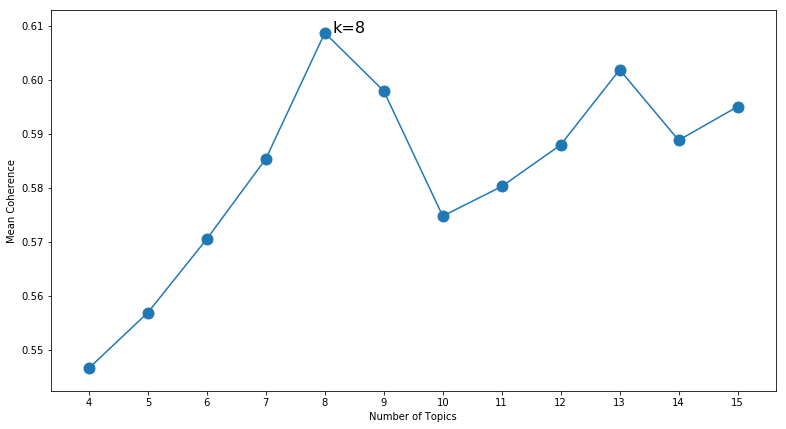

In [43]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [44]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: people, think, get, know, time, right, good, see, really, way
Topic 02: thanks, please, mail, know, advance, email, looking, info, address, edu
Topic 03: geb, cadre, dsl, chastity, n3jxp, shameful, pitt, intellect, skepticism, surrender
Topic 04: god, jesus, bible, believe, christ, faith, christian, christians, church, life
Topic 05: key, chip, encryption, clipper, keys, government, system, escrow, algorithm, public
Topic 06: drive, scsi, card, disk, drives, controller, hard, ide, floppy, bus
Topic 07: windows, file, dos, files, window, program, version, problem, running, screen
Topic 08: game, team, games, players, season, play, hockey, win, league, player


### UCI

### Umass

In [ ]:
sklearn.metrics.pairwise.cosine_distances(X, Y=None)
# x, y сжатые матрицы

In [30]:
from sklearn.neighbors import NearestNeighbors

class NewsRecommender:
    def __init__(self, texts=raw_documents, stopwords=custom_stop_words):
        self.texts = texts
        self.stopwords = stopwords
        self.vectorizer = TfidfVectorizer(min_df=20, stop_words=self.stopwords)
        
    def train(self):
        A = self.vectorizer.fit_transform(self.texts)
        model = LatentDirichletAllocation(n_components=12, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
        return NearestNeighbors(n_neighbors=k, algorithm='auto', metric='cosine').fit(model)
    def recommend(self, text_sample, k):
        B = self.vectorizer.transform(text_sample)
        И = text_sample.transform()
        neigh = self.train()
        n = neigh.kneighbors(B) 
        news = n.inverse_transform()
        print ([i for i in news])

In [32]:
check = NewsRecommender()
check.recommend(text_sample='football was played', k=10)

AttributeError: 'str' object has no attribute 'transform'

Read 1 raw text documents
